In [64]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# read data

In [54]:
words = open('../data/names.txt', 'r').read().splitlines()

In [55]:
len(words)

32033

In [56]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [57]:
chars = sorted(list(set(''.join(words))))

# util

In [58]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [59]:
stoi = {s: i for i, s in itos.items()}

In [60]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [61]:
block_size = 1
batch_size = 32

In [62]:
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [63]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 1]) torch.Size([182625])
torch.Size([22655, 1]) torch.Size([22655])
torch.Size([22866, 1]) torch.Size([22866])


# Train a neural language model

In [97]:
n_embd = 10
n_hidden = 200

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(n_embd, n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [98]:
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

7897


In [95]:
# parameters = model.parameters()
# list(parameters)

In [99]:
loglossi = []
lossi = []
# STEPS = 200_000
STEPS = 10_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    optimizer.zero_grad(set_to_none=True)
    # for p in parameters:
    #     p.grad = None
    loss.backward()

    # update
    optimizer.step()
    # lr = 0.1 if i < STEPS//2 else 0.01
    # for p in parameters:
    #     p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())
    
    # break

100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1540.94it/s]


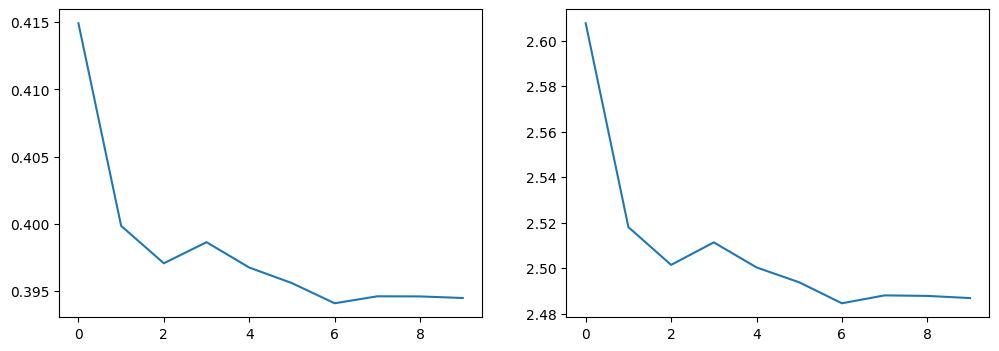

In [100]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(torch.tensor(loglossi[0:]).view(-1, 1000).mean(1))
plt.subplot(122)
plt.plot(torch.tensor(lossi[0:]).view(-1, 1000).mean(1))
plt.show()

## compute loss on train/dev/test

In [101]:
def eval_dataset(X, Y):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [102]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.479917526245117
2.4750640392303467


## visualize the embedding

In [103]:
from sklearn.manifold import TSNE

In [104]:
tsne = TSNE(n_components=2, verbose=1, random_state=1234, perplexity=3)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [105]:
z = tsne.fit_transform(model.layers[0].weight.detach().numpy())

AttributeError: 'Sequential' object has no attribute 'layers'

In [106]:
model.layers[0].weight.shape, z.shape

AttributeError: 'Sequential' object has no attribute 'layers'

In [107]:
plt.scatter(z[:,0].data, z[:,1].data, s=600)
for i in range(z.shape[0]):
    if itos[i] in 'aeiou':
        c = 'red'
    else:
        c = 'white'
    plt.text(z[i,0].item(), z[i,1].item(), itos[i], color=c)

NameError: name 'z' is not defined

# generate names

In [108]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [109]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carelixami.
hlelikimri.
reety.
skann.
ke.
mahnen.
deliaha.
kaqui.
nelenia.
chaiivin.
